In [1]:
import numpy as np
import pandas as pd
from autoviz import AutoViz_Class
import shap
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

data = pd.read_csv('salaries.csv')
data


Imported v0.1.806. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,90000,USD,90000,AE,0,AE,L
1,2024,SE,FT,Machine Learning Engineer,180500,USD,180500,US,0,US,M
2,2024,SE,FT,Machine Learning Engineer,96200,USD,96200,US,0,US,M
3,2024,SE,FT,Machine Learning Engineer,235000,USD,235000,AU,0,AU,M
4,2024,SE,FT,Machine Learning Engineer,175000,USD,175000,AU,0,AU,M
...,...,...,...,...,...,...,...,...,...,...,...
13967,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
13968,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
13969,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
13970,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [2]:
data.info()
useless_columns = ["salary", 'salary_currency']
data = data.drop(useless_columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13972 entries, 0 to 13971
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           13972 non-null  int64 
 1   experience_level    13972 non-null  object
 2   employment_type     13972 non-null  object
 3   job_title           13972 non-null  object
 4   salary              13972 non-null  int64 
 5   salary_currency     13972 non-null  object
 6   salary_in_usd       13972 non-null  int64 
 7   employee_residence  13972 non-null  object
 8   remote_ratio        13972 non-null  int64 
 9   company_location    13972 non-null  object
 10  company_size        13972 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.2+ MB


In [3]:
cat_cols = data.select_dtypes(include='object').columns
int_cols = data.select_dtypes(include="int64").columns

In [4]:
for col in cat_cols:
    print("\n")
    print(col, " : ", data[col].unique())



experience_level  :  ['SE' 'MI' 'EN' 'EX']


employment_type  :  ['FT' 'CT' 'PT' 'FL']


job_title  :  ['AI Engineer' 'Machine Learning Engineer'
 'Business Intelligence Developer' 'Data Engineer' 'Data Scientist'
 'Cloud Database Engineer' 'Research Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Applied Scientist' 'Data Science Manager'
 'Research Scientist' 'Prompt Engineer' 'Data Science'
 'Data Science Consultant' 'Data Management Analyst' 'Research Analyst'
 'Data Operations Analyst' 'Data Management Consultant'
 'Business Intelligence Analyst' 'Analytics Engineer'
 'Data Quality Analyst' 'Data Architect' 'Data Manager' 'ML Engineer'
 'Robotics Software Engineer' 'Machine Learning Researcher' 'AI Architect'
 'Data DevOps Engineer' 'Business Intelligence' 'AI Software Engineer'
 'Data Integration Engineer' 'Data Operations Specialist' 'BI Analyst'
 'Data Product Manager' 'Business Intelligence Engineer' 'Data Specialist'
 'AI Research Scientist' 'Data Science Director' '

In [5]:
# Преобразуем данные
from feature_engine.encoding import RareLabelEncoder

label = 'salary_in_usd'
data[label] = data[label] * 1e-3 # Зарплата в долларах -> Зарплата в тысячах долларов

percentile = np.percentile(data[label], [1, 99])
data = data[(data[label] > percentile[0]) & data[label] < percentile[1]]

experience_level = {
    "SE": "Senior-level / Expert",
    "MI": "Middle-level / Intermidate",
    "EN": "Entry-level / Junior",
    "EX": "Executive-level / Director"
}
data["experience_level"] = data['experience_level'].replace(experience_level)

data['job_title'].replace("ML Engineer", "Machine Learning Engineer", inplace=True)

employment_type = {
    "FT": "Full-time",
    "CT": "Contract",
    "PT": "Part-time",
    "FL": "Freelance"
}

data["employment_type"] = data['employment_type'].replace(employment_type)

remote_ratio = {
    0: 'No remote work',
    50: 'Half remote work',
    100: "Fully remote work"
}
data['remote_ratio'] = data['remote_ratio'].replace(remote_ratio)

company_size = {
    "L": "Large",
    "M": "Medium",
    "S": "Small"
}
data['company_size'] = data['company_size'].replace(company_size)

for col in ['experience_level', 'job_title', 'employment_type', 'company_location', 'employee_residence']:
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with="Other", tol=20/data.shape[0])
    data[col] = encoder.fit_transform(data[[col]])

In [6]:
data.sample(10).T

,9724,8956,1061,7861,495,4574,13765,3877,11347,5308
work_year,2023,2023,2024,2023,2024,2023,2021,2023,2023,2023
experience_level,Senior-level / Expert,Senior-level / Expert,Middle-level / Intermidate,Middle-level / Intermidate,Middle-level / Intermidate,Middle-level / Intermidate,Entry-level / Junior,Middle-level / Intermidate,Senior-level / Expert,Senior-level / Expert
employment_type,Full-time,Full-time,Full-time,Full-time,Full-time,Full-time,Full-time,Full-time,Full-time,Full-time
job_title,Data Scientist,Applied Scientist,Data Analyst,Other,Data Scientist,Applied Scientist,Data Analyst,Business Intelligence Analyst,Data Engineer,Data Scientist
salary_in_usd,160.0,309.4,147.0,44.64,73.1,136.0,60.0,96.0,104.0,104.0
employee_residence,US,US,US,US,US,US,US,US,US,CA
remote_ratio,Fully remote work,No remote work,No remote work,Fully remote work,No remote work,No remote work,Fully remote work,Fully remote work,Fully remote work,Fully remote work
company_location,US,US,US,US,US,US,US,US,US,CA
company_size,Medium,Large,Medium,Medium,Medium,Large,Small,Medium,Medium,Medium


In [8]:
y = data['salary_in_usd'].values.reshape(-1,)
X = data.drop(['salary_in_usd'], axis=1)

cat_cols = data.select_dtypes(include='object').columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=0, stratify=data[['employee_residence']])

print("Training set shape X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("Test set shape X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

Training set shape X_train: (6986, 8), y_train: (6986,)
Test set shape X_test: (6986, 8), y_test: (6986,)


In [10]:
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)

test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)

model = CatBoostRegressor(iterations = 800,
                          depth=6,
                          verbose=1,
                          early_stopping_rounds=100,
                          learning_rate=0.008,
                          loss_function="RMSE")

model.fit(train_pool, eval_set=test_pool)


0:	learn: 69.0289326	test: 67.9507078	best: 67.9507078 (0)	total: 168ms	remaining: 2m 14s
1:	learn: 68.8876955	test: 67.7985961	best: 67.7985961 (1)	total: 203ms	remaining: 1m 20s
2:	learn: 68.7448910	test: 67.6439633	best: 67.6439633 (2)	total: 233ms	remaining: 1m 1s
3:	learn: 68.6027578	test: 67.4925022	best: 67.4925022 (3)	total: 262ms	remaining: 52.1s
4:	learn: 68.4866629	test: 67.3671364	best: 67.3671364 (4)	total: 287ms	remaining: 45.6s
5:	learn: 68.3468661	test: 67.2209908	best: 67.2209908 (5)	total: 312ms	remaining: 41.3s
6:	learn: 68.2151383	test: 67.0806004	best: 67.0806004 (6)	total: 339ms	remaining: 38.4s
7:	learn: 68.0833589	test: 66.9380056	best: 66.9380056 (7)	total: 378ms	remaining: 37.5s
8:	learn: 67.9515208	test: 66.7972111	best: 66.7972111 (8)	total: 404ms	remaining: 35.5s
9:	learn: 67.8265117	test: 66.6610574	best: 66.6610574 (9)	total: 434ms	remaining: 34.3s
10:	learn: 67.7012070	test: 66.5237919	best: 66.5237919 (10)	total: 459ms	remaining: 32.9s
11:	learn: 67.582

In [11]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test= mean_squared_error(y_test, y_test_pred, squared=False)

print(f"RMSE score for train {round(rmse_train, 1)} kUSD/year, and for test {round(rmse_test, 1)} kUSD/year")

RMSE score for train 56.7 kUSD/year, and for test 55.5 kUSD/year


In [48]:
X_test

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
4024,2023,Entry-level / Junior,Full-time,Data Scientist,US,No remote work,US,Medium
8881,2023,Senior-level / Expert,Full-time,Machine Learning Engineer,US,No remote work,US,Medium
1919,2024,Senior-level / Expert,Full-time,Data Engineer,US,No remote work,US,Medium
7356,2023,Senior-level / Expert,Full-time,Data Architect,US,No remote work,US,Medium
5605,2023,Senior-level / Expert,Full-time,Data Scientist,US,Fully remote work,US,Medium
...,...,...,...,...,...,...,...,...
5889,2023,Executive-level / Director,Full-time,Data Lead,US,No remote work,US,Medium
3113,2024,Senior-level / Expert,Full-time,Data Engineer,US,No remote work,US,Medium
8953,2023,Senior-level / Expert,Full-time,Applied Scientist,US,No remote work,US,Large
10968,2023,Middle-level / Intermidate,Full-time,Data Analyst,US,No remote work,US,Medium


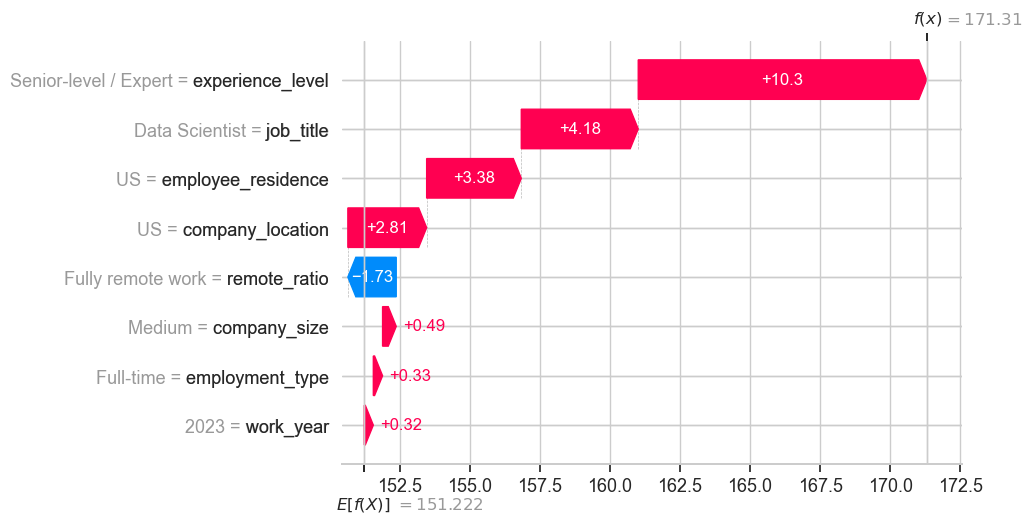

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
shap.initjs()

ex = shap.Explainer(model)

# Compute SHAP values for the test dataset 'X_test' using the TreeExplainer
shap_values = ex(X_test)

# Generate a summary plot of SHAP values to visualize feature contributions
shap.plots.waterfall(shap_values[4])

In [65]:
shap.plots.force(shap_values[4])

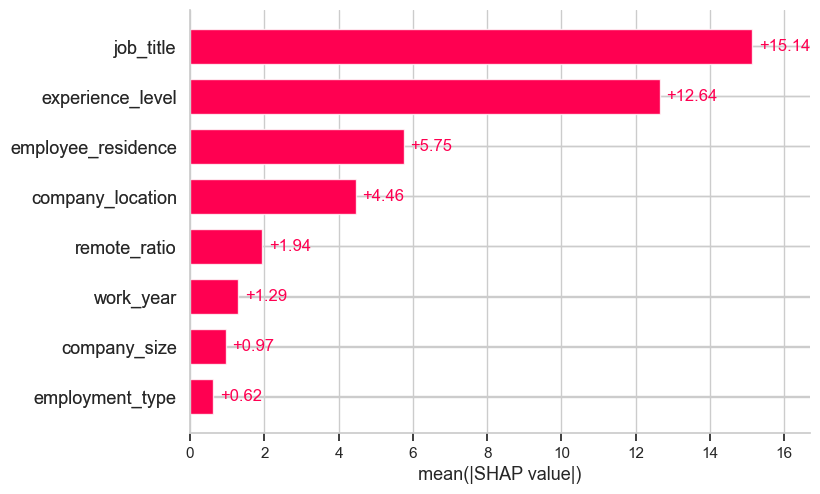

In [66]:
shap.plots.bar(shap_values)

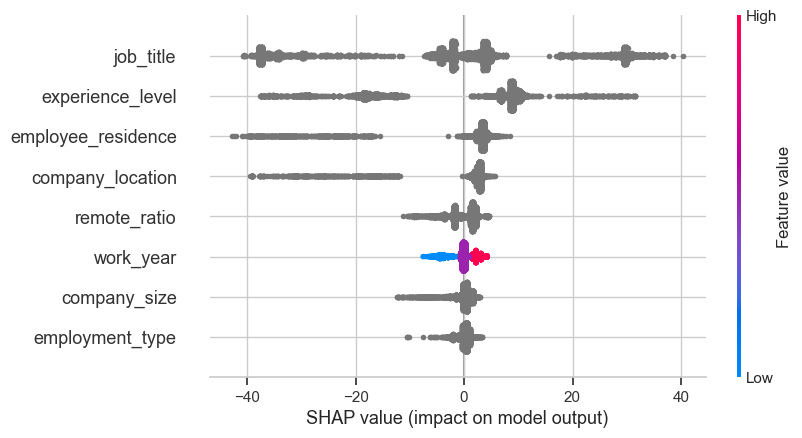

In [67]:
shap.plots.beeswarm(shap_values)

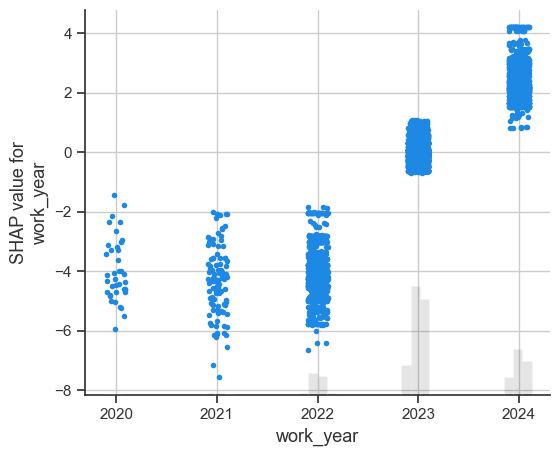

In [69]:
shap.plots.scatter(shap_values[:, 'work_year'])